In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import torch.utils.data as Data

import torchvision.transforms as transforms


In [2]:
train_read_data = pd.read_csv('./data/train.csv')
test_read_data = pd.read_csv('./data/test.csv')

cuda


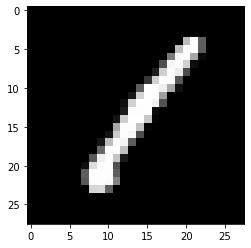

In [3]:
train_num = train_read_data.shape[0] * 0.8

train_x = train_read_data.drop(['label'], axis=1).values
train_x = train_x.reshape(-1, 1, 28, 28)
train_y = train_read_data['label'].values

val_x = train_x[int(train_num):]
val_y = train_y[int(train_num):]

train_x = train_x[:int(train_num)]
train_y = train_y[:int(train_num)]

test_x = test_read_data.values
test_x = test_x.reshape(-1, 1, 28, 28)

dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
plt.imshow(train_x[0][0], cmap='gray')

In [4]:
# 数据预处理(目前仅仅把数据转成tensor)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.5], std=[0.5])
# ])

train_data_set = Data.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
val_data_set = Data.TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data_set = Data.TensorDataset(torch.from_numpy(test_x))

train_data = Data.DataLoader(train_data_set, batch_size=512, shuffle=True)
val_data = Data.DataLoader(train_data_set, batch_size=512, shuffle=True)
test_data = Data.DataLoader(test_data_set, batch_size=400, shuffle=False)

for step, (x, y) in enumerate(train_data):
    print(x.shape)
    print(y.shape)
    break

torch.Size([512, 1, 28, 28])
torch.Size([512])


In [5]:
# 定义网络
class cifar10_net(nn.Module):
    def __init__(self):
        super(cifar10_net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
        nn.init.kaiming_normal_(self.out.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 32 * 7 * 7)
        output = self.out(x)
        return output




In [6]:
# 定义训练函数
def train(model, train_data, val_data, optimizer, loss_func, epoch):
    model = model.to(device=device)
    for i in range(epoch):
        for step, (x, y) in enumerate(train_data):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            output = model(x)
            loss = loss_func(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step % 50 == 0:
                print('epoch: {}, step: {}, loss: {}'.format(i, step, loss.item()))
                val(model, val_data)


# 定义验证函数
def val(model, val_data):
    correct = 0
    total = 0
    for step, (x, y) in enumerate(val_data):
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        output = model(x)
        _, pred = torch.max(output, 1)
        correct += (pred == y).sum().item()
        total += y.shape[0]
    print('acc: {}'.format(correct / total))

In [7]:
# 定义模型
cifar10_net = cifar10_net()
# 定义优化器
optimizer = torch.optim.Adam(cifar10_net.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
train(cifar10_net, train_data, val_data, optimizer, loss_func, 10)

epoch: 0, step: 0, loss: 50.458370208740234
acc: 0.08172619047619048
epoch: 0, step: 50, loss: 0.6202016472816467
acc: 0.8792261904761904
epoch: 1, step: 0, loss: 0.3561955392360687
acc: 0.9002678571428572
epoch: 1, step: 50, loss: 0.21133464574813843
acc: 0.9324404761904762
epoch: 2, step: 0, loss: 0.2933654189109802
acc: 0.940595238095238
epoch: 2, step: 50, loss: 0.19773411750793457
acc: 0.9535714285714286
epoch: 3, step: 0, loss: 0.1783764809370041
acc: 0.9587797619047619
epoch: 3, step: 50, loss: 0.2053975611925125
acc: 0.9649404761904762
epoch: 4, step: 0, loss: 0.09919382631778717
acc: 0.9707738095238095
epoch: 4, step: 50, loss: 0.09171508252620697
acc: 0.9744047619047619
epoch: 5, step: 0, loss: 0.11855461448431015
acc: 0.9752380952380952
epoch: 5, step: 50, loss: 0.10015727579593658
acc: 0.9800892857142857
epoch: 6, step: 0, loss: 0.06331959366798401
acc: 0.981875
epoch: 6, step: 50, loss: 0.08329681307077408
acc: 0.9828869047619048
epoch: 7, step: 0, loss: 0.0265368409454822

In [8]:
# 定义预测函数
def predict(model, test_data):
    model = model.to(device=device)
    result = []
    for step, (x) in enumerate(test_data):
        x = x[0].to(device=device, dtype=dtype)
        output = model(x)
        _, pred = torch.max(output, 1)
        result.append(pred)
    return result


In [9]:
# 写入文件
result = predict(cifar10_net, test_data)
result = torch.cat(result, dim=0).cpu().numpy()
result = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': result})
result.to_csv('./data/result.csv', index=False)